In [1]:
import os
import sys
import copy
import json
import importlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import time
import torch
import torchaudio
import tensorflow as tf
import tqdm

import peripheral_model
import perceptual_model
import phaselocknet_model
import util

importlib.reload(peripheral_model)
importlib.reload(perceptual_model)
importlib.reload(phaselocknet_model)
importlib.reload(util)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device


2024-11-20 03:59:54.523763: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


device(type='cuda', index=0)

In [22]:
"""
Specify model directory, input shape, and parameters for randomly excerpting input
"""
# dir_model = "../phaselocknet/models/sound_localization/simplified_IHC3000_delayed_integration/arch02"
# input_shape = [2, 60000, 2]
# config_random_slice = {"size": [50, 10000], "buffer": [0, 1000]}

# dir_model = "../phaselocknet/models/sound_localization/simplified_IHC3000/arch02"
# input_shape = [2, 60000, 2]
# config_random_slice = {"size": [50, 10000], "buffer": [0, 1000]}

# dir_model = "../phaselocknet/models/sound_localization/IHC3000_delayed_integration/arch02"
# input_shape = [2, 3, 50, 12000, 2]
# config_random_slice = {"size": [50, 10000], "buffer": [0, 500]}

dir_model = "../phaselocknet/models/spkr_word_recognition/simplified_IHC3000/arch0_0000"
input_shape = [2, 40000]
config_random_slice = {"size": [50, 20000], "buffer": [0, 0]}

# dir_model = "../phaselocknet/models/spkr_word_recognition/IHC3000/arch0_0000"
# input_shape = [2, 3, 50, 20000]
# config_random_slice = {}

# dir_model = "../phaselocknet/models/sound_localization/simplified_IHC3000_delayed_integration/arch02"
# input_shape = [2, 50000, 2]
# config_random_slice = {"size": [50, 10000], "buffer": [0, 0]}

REMOVE_STOCHASTICITY = True # If true, remove stochastic spike sampling stage from cochlear model


In [23]:
"""
Construct torch model object
"""
with open(os.path.join(dir_model, "config.json")) as f:
    config_model = json.load(f)
with open(os.path.join(dir_model, "arch.json")) as f:
    architecture = json.load(f)

if REMOVE_STOCHASTICITY:
    config_model["kwargs_cochlea"]["kwargs_spike_generator_binomial"] = {}

model = phaselocknet_model.Model(
    config_model=copy.deepcopy(config_model),
    architecture=copy.deepcopy(architecture),
    input_shape=input_shape,
    config_random_slice=copy.deepcopy(config_random_slice),
).to(device)

for k, v in model(torch.zeros(model.input_shape, device=device)).items():
    print(k, v.shape, v.dtype)

util.load_tf_model_checkpoint(
    model=model.perceptual_model,
    filename=os.path.join(dir_model, "ckpt_BEST"),
)
model.train(mode=False)


[WARNING] layer_type='reshape' --> torch.nn.Identity
label_speaker_int torch.Size([2, 433]) torch.float32
label_word_int torch.Size([2, 794]) torch.float32
[load_tf_model_checkpoint] missing_keys (../phaselocknet/models/spkr_word_recognition/simplified_IHC3000/arch0_0000/ckpt_BEST)
|__ body.block0_pool.weight
|__ body.block1_pool.weight
|__ body.block2_pool.weight
|__ body.block3_pool.weight
|__ body.block4_pool.weight
|__ body.block5_pool.weight
|__ body.block6_pool.weight
[load_tf_model_checkpoint] ../phaselocknet/models/spkr_word_recognition/simplified_IHC3000/arch0_0000/ckpt_BEST


Model(
  (peripheral_model): PeripheralModel(
    (body): Sequential(
      (cochlear_filterbank): GammatoneFilterbank(
        (fb): FIRFilterbank()
      )
      (ihc_transduction): IHCTransduction()
      (ihc_lowpass_filter): IHCLowpassFilter()
      (anf_rate_level): SigmoidRateLevelFunction(
        (envelope_function): HilbertEnvelope(
          (hilbert): Hilbert()
        )
      )
    )
    (head): RandomSlice(
      (crop): RandomCrop(size=(50, 20000), padding=None)
    )
  )
  (perceptual_model): PerceptualModel(
    (body): Sequential(
      (input_reshape): Identity()
      (input_norm): CustomNorm()
      (block0_conv): CustomPaddedConv2d(3, 32, kernel_size=(2, 42), stride=(1, 1))
      (block0_relu): ReLU()
      (block0_pool): HanningPooling()
      (block0_norm): CustomNorm()
      (block1_conv): CustomPaddedConv2d(32, 64, kernel_size=(2, 18), stride=(1, 1))
      (block1_relu): ReLU()
      (block1_pool): HanningPooling()
      (block1_norm): CustomNorm()
      (bloc

In [24]:
"""
Construct tensorflow model object
"""
sys.path.append("../phaselocknet")
import util_cochlea
import util_network
import util_signal

with open(os.path.join(dir_model, "config.json")) as f:
    config_model = json.load(f)
with open(os.path.join(dir_model, "arch.json")) as f:
    architecture = json.load(f)

if REMOVE_STOCHASTICITY:
    config_model["kwargs_cochlea"]["kwargs_spike_generator_binomial"] = {}


def model_io_function(x):
    y = x
    if config_model.get("kwargs_cochlea", {}):
        if "label_loc_int" in config_model["n_classes_dict"]:
            msg = "expected [batch, freq, time, spont, channel=2] or [batch, time, channel=2]"
            assert (len(y.shape) in [3, 5]) and (y.shape[-1] == 2), msg
            y0, _ = util_cochlea.cochlea(y[..., 0], **copy.deepcopy(config_model["kwargs_cochlea"]))
            y1, _ = util_cochlea.cochlea(y[..., 1], **copy.deepcopy(config_model["kwargs_cochlea"]))
            y = tf.concat([y0, y1], axis=-1)
            if y.shape[2] > config_random_slice["size"][1]:
                print(y.shape, y.shape, y.shape)
                y = util_cochlea.random_slice(
                    y,
                    slice_length=config_random_slice["size"][1],
                    axis=2, # Time axis
                    buffer=config_random_slice["buffer"][1],
                )
        else:
            y, _ = util_cochlea.cochlea(y, **copy.deepcopy(config_model["kwargs_cochlea"]))
    y, _ = util_network.build_network(y, architecture, n_classes_dict=config_model["n_classes_dict"])
    return y


inputs = tf.keras.Input(shape=input_shape[1:], batch_size=None, dtype=tf.float32)
tf_model = tf.keras.Model(inputs=inputs, outputs=model_io_function(inputs))
tf_model.load_weights(os.path.join(dir_model, "ckpt_BEST"))
tf_model.summary()


[cochlea] converting audio to subbands using fir_gammatone_filterbank
[cochlea] half-wave rectified subbands
[tf_fir_resample] interpreted `tensor_input.shape` as [batch, freq=50, time=40000]
[tf_fir_resample] `kwargs_fir_lowpass_filter`: {'cutoff': 3000, 'fir_dur': 0.05, 'ihc_filter': True, 'order': 7}
[fir_lowpass_filter] sr_filt = 20000.0 Hz
[fir_lowpass_filter] numtaps = 1001 samples
[fir_lowpass_filter] fir_dur = 0.05 seconds
[fir_lowpass_filter] cutoff = 3000 Hz
[fir_lowpass_filter] order = 7 (bez2018model IHC filter)
[cochlea] resampled subbands from 20000 Hz to 10000 Hz with filter: {'cutoff': 3000, 'fir_dur': 0.05, 'ihc_filter': True, 'order': 7}
[cochlea] half-wave rectified resampled subbands
[cochlea] incorporated sigmoid_rate_level_function: {'dynamic_range': [20.0, 40.0, 80.0], 'dynamic_range_interval': 0.95, 'envelope_mode': True, 'rate_max': [250.0, 250.0, 250.0], 'rate_spont': [0.0, 0.0, 0.0], 'threshold': [0.0, 12.0, 28.0]}
Model: "model_1"
___________________________

In [25]:
x = np.random.randn(*input_shape).astype(np.float32)

model.eval()
out_torch = model(torch.tensor(x).to(device))
print(f"PyTorch model outputs:")
for k in out_torch.keys():
    out_torch[k] = out_torch[k].cpu().detach().numpy()
    print(f"|__ {k}, {out_torch[k].dtype}, {out_torch[k].shape}")

out_tf = tf_model(x, training=False)
print(f"TensorFlow model outputs:")
for k in out_tf.keys():
    out_tf[k] = out_tf[k].numpy()
    print(f"|__ {k}, {out_tf[k].dtype}, {out_tf[k].shape}")


PyTorch model outputs:
|__ label_speaker_int, float32, (2, 433)
|__ label_word_int, float32, (2, 794)
TensorFlow model outputs:
|__ label_speaker_int, float32, (2, 433)
|__ label_word_int, float32, (2, 794)


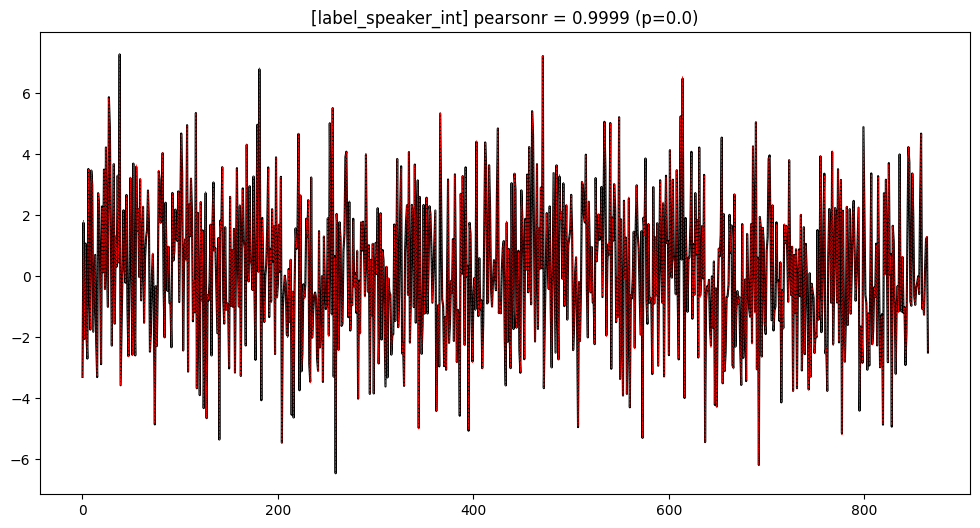

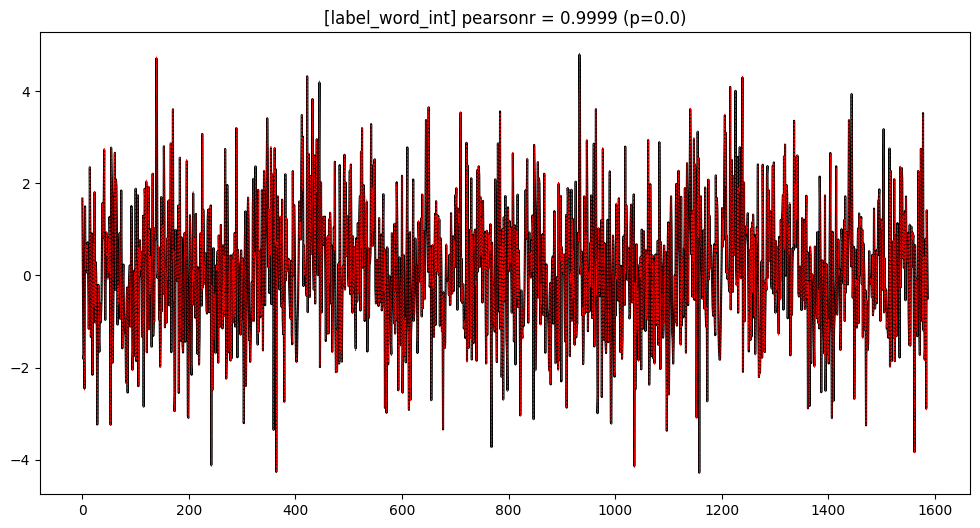

In [26]:
assert list(out_torch.keys()) == list(out_tf.keys())

for k in out_torch.keys():
    x0 = out_torch[k].reshape([-1])
    x1 = out_tf[k].reshape([-1])

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(x0, ls="-", color="k")
    ax.plot(x1, ls="--", color="r", lw=0.5)
    r, p = scipy.stats.pearsonr(x0, x1)
    ax.set_title("[{}] pearsonr = {:.04f} (p={})".format(k, r, p))
    plt.show()


In [ ]:
for _ in tqdm.tqdm(range(20)):
    x = torch.randn(model.input_shape, device=device)
    model(x)
x.shape


In [ ]:
# regex_filenames = "../phaselocknet/stimuli/sound_localization/evaluation/speech_in_noise_in_reverb_v04/stim.hdf5"
# regex_filenames = "../phaselocknet/stimuli/sound_localization/evaluation/mp_spectral_cues/stim.hdf5"
regex_filenames = "../phaselocknet/stimuli/spkr_word_recognition/evaluation/pitch_altered_v00/stim.hdf5"
batch_size = 32
sr = 50000 if "sound_localization" in regex_filenames else 20000
num_steps_per_display = 10
dataset = util.HDF5Dataset(regex_filenames)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    num_workers=1,
    shuffle=False,
)


In [ ]:
fn_eval_output = "tmp.csv"
overwrite = True
write_prob = True

if os.path.exists(fn_eval_output):
    if overwrite:
        print(f"[evaluate] Overwriting pre-existing {fn_eval_output=}")
        os.remove(fn_eval_output)
    else:
        print(f"[complete] {fn_eval_output=} already exists!")
        raise ValueError(f"[complete] {fn_eval_output=} already exists!")
if os.path.exists(fn_eval_output + "~"):
    print(f"[evaluate] Deleting pre-existing tempfile: {fn_eval_output}~")
    os.remove(fn_eval_output + "~")

if write_prob:
    df_prob = []
    fn_eval_prob = fn_eval_output.replace(".csv", "_prob.gz")
    if os.path.exists(fn_eval_prob):
        print(f"[evaluate] Deleted pre-existing {fn_eval_prob=}")
        os.remove(fn_eval_prob)

model.eval()
with torch.no_grad():
    t0 = time.time()
    for step, example in enumerate(dataloader):
        x = example.pop("signal").type(torch.float32)
        sr_src = example["sr"][0].item()
        if step == 0:
            resampler = torchaudio.transforms.Resample(
                orig_freq=sr_src,
                new_freq=sr,
            )
            print(f"[evaluate] resampling audio from {sr_src} to {sr} Hz")
        if x.ndim > 2:
            x = torch.stack(
                [resampler(x[..., channel]) for channel in range(x.shape[-1])],
                axis=-1,
            )
        else:
            x = resampler(x)
            if len(model.input_shape) > 2:
                x = torch.stack([x for _ in range(model.input_shape[-1])], axis=-1)
        x = util.pad_or_trim_to_len(x, n=model.input_shape[1], dim=1)
        assert list(x.shape[1:]) == list(model.input_shape[1:])
        task_logits = model(x.to(device))
        task_preds = {
            k + ".pred": torch.argmax(v, dim=1) for k, v in task_logits.items()
        }
        example.update(task_preds)
        if write_prob:
            task_prob = {
                k + ".prob": torch.nn.functional.softmax(v, dim=1)
                for k, v in task_logits.items()
            }
            df_prob.append(
                pd.DataFrame(
                    {
                        k: list(v.detach().cpu().numpy())
                        for k, v in sorted(task_prob.items())
                    }
                )
            )
        example = {
            k: list(v.detach().cpu().numpy()) for k, v in sorted(example.items())
        }
        df = pd.DataFrame(example)
        df.to_csv(
            fn_eval_output + "~",
            mode="a",
            header=not os.path.exists(fn_eval_output + "~"),
            index=False,
        )
        if step % num_steps_per_display == num_steps_per_display - 1:
            display_str = util.get_model_progress_display_str(
                epoch=0,
                step=step + 1,
                num_steps=step + 1,
                t0=t0,
                mem=True,
            )
            print(display_str)
if write_prob:
    df_prob = pd.concat(df_prob).reset_index(drop=True)
    df_prob.to_pickle(fn_eval_prob + "~", compression="gzip")
    os.rename(fn_eval_prob + "~", fn_eval_prob)
    print(f"[complete] {fn_eval_prob=}")
os.rename(fn_eval_output + "~", fn_eval_output)
print(f"[complete] {fn_eval_output=}")


In [ ]:
df0 = pd.read_csv(fn_eval_output)
fn = os.path.join(dir_model, "EVAL_PSYCHOPHYSICSv00_mp_spectral_cues.json")
df1 = pd.read_json(fn).sort_values(by="index").reset_index(drop=True)

for c in df1.columns:
    if c in df0.columns:
        print(c, np.array_equal(df0[c].values, df1[c].values))
    else:
        print("!", c)

fig, ax = plt.subplots()
x = df1["label_loc_int:labels_pred"].values
y = df0["label_loc_int.pred"].values
ax.plot(x + 5 * np.random.randn(*y.shape), y + 5 * np.random.randn(*y.shape), "k.", ms=0.2)
plt.show()

scipy.stats.pearsonr(x, y), scipy.stats.spearmanr(x, y)


In [ ]:
df0 = pd.read_csv(fn_eval_output)
fn = os.path.join(dir_model, "EVAL_PSYCHOPHYSICSv00_speech_in_noise_in_reverb_v04.json")
df1 = pd.read_json(fn).sort_values(by="index").reset_index(drop=True)

df0 = df0.sort_values(
    by=[
        "index",
        "snr",
        "index_room",
        "index_brir",
        "label_speaker_int",
        "label_word_int",
    ]
)
df1 = df1.sort_values(
    by=[
        "index",
        "snr",
        "index_room",
        "index_brir",
        "label_speaker_int",
        "label_word_int",
    ]
)

fig, ax = plt.subplots()
x = df1["label_loc_int:labels_pred"].values
y = df0["label_loc_int.pred"].values
ax.plot(x + 1 * np.random.randn(*y.shape), y + 1 * np.random.randn(*y.shape), "k.", ms=0.2)
plt.show()

scipy.stats.pearsonr(x, y), scipy.stats.spearmanr(x, y)


In [ ]:
df0 = pd.read_csv(fn_eval_output)
fn = os.path.join(dir_model, "EVAL_pitch_altered_v00.json")
df1 = pd.read_json(fn).sort_values(by="index").reset_index(drop=True)

fig, ax = plt.subplots()
x = df1["label_speaker_int:labels_pred"].values
y = df0["label_speaker_int.pred"].values
ax.plot(x + 1 * np.random.randn(*y.shape), y + 1 * np.random.randn(*y.shape), "k.", ms=0.2)
plt.show()

scipy.stats.pearsonr(x, y), scipy.stats.spearmanr(x, y)
